In [15]:
# =============================================
# 📦 EV Charger Availability - Data Collection
# =============================================

import requests
import pandas as pd
import time
from datetime import datetime
import os

# 📌 Configurations
API_KEY = "xwG3dZUx5dMlrHyt7rEY8gRHEBZ1Z3Dp"
BASE_URL = "https://api.tomtom.com"
LAT, LON = -37.8136, 144.9631  # Melbourne
RADIUS = 100000  # 100 km
SAVE_FOLDER = "data/raw/"
os.makedirs(SAVE_FOLDER, exist_ok=True)

# 🚗 Fetch Charging Stations
def fetch_charging_stations(lat, lon, radius, api_key):
    url = f"{BASE_URL}/search/2/categorySearch/charging station.json"
    params = {
        "key": api_key,
        "lat": lat,
        "lon": lon,
        "radius": radius,
        "categorySet": "7309",
        "limit": 50
    }
    response = requests.get(url, params=params)
    stations = []
    if response.status_code == 200:
        data = response.json()
        for result in data.get("results", []):
            station = {
                "Name": result.get("poi", {}).get("name", "Unknown"),
                "Charger_ID": result.get("dataSources", {}).get("chargingAvailability", {}).get("id", None),
                "Latitude": result.get("position", {}).get("lat"),
                "Longitude": result.get("position", {}).get("lon")
            }
            if station["Charger_ID"]:  # Only keep if we have ID
                stations.append(station)
    else:
        print(f"Station Fetch Error: {response.status_code}")
    return stations

def fetch_availability(charger_id, api_key):
    url = f"{BASE_URL}/search/2/chargingAvailability.json"
    params = {
        "key": api_key,
        "chargingAvailability": charger_id
    }
    response = requests.get(url, params=params)
    
    if response.status_code == 200:
        data = response.json()
        if "connectors" in data and len(data["connectors"]) > 0:
            conn = data["connectors"][0]
            return {
                "Status": "Available",   # or conn.get("availability", {}).get("currentStatus", "Unknown")
                "Available_Connectors": conn.get("availability", {}).get("current", {}).get("available", 0),
                "Busy_Connectors": conn.get("availability", {}).get("current", {}).get("occupied", 0),
                "Power_kW": conn.get("powerKW", "N/A"),
                "Connector_Type": conn.get("connectorType", "N/A")
            }
        else:
            return {
                "Status": "Unknown",
                "Available_Connectors": "N/A",
                "Busy_Connectors": "N/A",
                "Power_kW": "N/A",
                "Connector_Type": "N/A"
            }
    else:
        print(f"Availability API Error for {charger_id}: {response.status_code} - {response.text}")
        return {
            "Status": "Error",
            "Available_Connectors": "N/A",
            "Busy_Connectors": "N/A",
            "Power_kW": "N/A",
            "Connector_Type": "N/A"
        }


# 📦 Collect Availability Snapshot and Save
def collect_availability_snapshot(lat, lon, radius, api_key):
    stations = fetch_charging_stations(lat, lon, radius, api_key)
    
    if not stations:
        print("No stations found ❌")
        return
    
    final_data = []
    timestamp = datetime.utcnow().isoformat()

    for station in stations:
        availability = fetch_availability(station["Charger_ID"], api_key)
        combined = {
            **station,
            **availability,
            "Timestamp": timestamp
        }
        final_data.append(combined)
        time.sleep(1)  # Respectful delay to avoid hitting API limit

    df = pd.DataFrame(final_data)
    filename = f"{SAVE_FOLDER}/availability_snapshot.csv"
    df.to_csv(filename, index=False)
    print(f"✅ Saved snapshot: {filename}")
    return df

# 🚀 Manual run once
df_snapshot = collect_availability_snapshot(LAT, LON, RADIUS, API_KEY)
df_snapshot.head()


✅ Saved snapshot: data/raw//availability_snapshot.csv


,Name,Charger_ID,Latitude,Longitude,Status,Available_Connectors,Busy_Connectors,Power_kW,Connector_Type,Timestamp
0,ChargeFox,291f046e-463c-46a4-8ce6-26d113469971,-37.815888,144.959594,Available,9,1,N/A,N/A,2025-04-26T12:35:52.696766
1,ChargeFox,49293063-d71c-4093-b273-0cb3401a1056,-37.806270,144.963977,Available,0,0,N/A,N/A,2025-04-26T12:35:52.696766
2,Exploren,6f2732e0-29e7-4dbc-a804-5544773beeed,-37.822328,144.967133,Available,2,0,N/A,N/A,2025-04-26T12:35:52.696766
3,Exploren,e038a32a-5442-4218-b3b3-ca08ec135dec,-37.802178,144.967164,Available,1,0,N/A,N/A,2025-04-26T12:35:52.696766
4,ChargeFox,00887bb2-1a22-4369-bc62-bd037695d12f,-37.825561,144.948657,Available,3,0,N/A,N/A,2025-04-26T12:35:52.696766


In [17]:
# 🚀 Start scheduled collection
import time

# Parameters
TOTAL_MINUTES = 5 * 24 * 60  # 5 days
INTERVAL_MINUTES = 5  # Every 5 minutes

runs_needed = TOTAL_MINUTES // INTERVAL_MINUTES
print(f"Scheduled runs: {runs_needed} times (one every 5 min for 5 days)")

counter = 0

while counter < runs_needed:
    print(f"\n🚀 Collecting snapshot #{counter+1} / {runs_needed}")
    try:
        df_snapshot = collect_availability_snapshot(LAT, LON, RADIUS, API_KEY)
        
        # 🖨️ Print **full table** with all important columns:
        display_columns = [
            "Name", "Charger_ID", "Latitude", "Longitude",
            "Status", "Available_Connectors", "Busy_Connectors",
            "Power_kW", "Connector_Type", "Timestamp"
        ]
        
        print(df_snapshot[display_columns].head(10))  # Show top 10 rows nicely
        
    except Exception as e:
        print(f"❌ Error during fetching: {e}")
    
    counter += 1
    print(f"✅ Waiting {INTERVAL_MINUTES} minutes before next fetch...\n")
    time.sleep(INTERVAL_MINUTES * 60)  # Sleep for 5 minutes


Scheduled runs: 1440 times (one every 5 min for 5 days)

🚀 Collecting snapshot #1 / 1440
✅ Saved snapshot: data/raw//availability_snapshot.csv
                            Name                            Charger_ID  \
0                      ChargeFox  291f046e-463c-46a4-8ce6-26d113469971   
1                      ChargeFox  49293063-d71c-4093-b273-0cb3401a1056   
2                       Exploren  6f2732e0-29e7-4dbc-a804-5544773beeed   
3                       Exploren  e038a32a-5442-4218-b3b3-ca08ec135dec   
4                      ChargeFox  00887bb2-1a22-4369-bc62-bd037695d12f   
5  Saascharge International GmbH  83188e00-c87d-4c1c-9b0c-5153eb100563   
6                      ChargeFox  fcb1d2d5-32a5-4f09-9202-455bdcab0a1e   
7                           Evie  de51892d-e7e0-425a-905e-8d0f786afc34   

    Latitude   Longitude     Status  Available_Connectors  Busy_Connectors  \
0 -37.815888  144.959594  Available                     9                1   
1 -37.806270  144.963977  Availabl

In [1]:
import os

print(os.getcwd())  # Shows your current working directory


C:\Users\gouth


In [2]:
# ================================================
# 📦 EV Charger Availability - Phase 2: Feature Engineering
# ================================================

import pandas as pd
import numpy as np

# 🚀 Load the main 1440-snapshot dataset
df = pd.read_csv("combined_snapshots.csv")

print("✅ Data loaded! Records:", len(df))
df.head()


C:\Users\gouth\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\gouth\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


✅ Data loaded! Records: 11512


,Name,Charger_ID,Latitude,Longitude,Status,Available_Connectors,Busy_Connectors,Power_kW,Connector_Type,Timestamp
0,ChargeFox,291f046e-463c-46a4-8ce6-26d113469971,-37.815888,144.959594,Available,9,1,NaN,NaN,2025-04-26T12:44:23.392227
1,ChargeFox,49293063-d71c-4093-b273-0cb3401a1056,-37.806270,144.963977,Available,0,0,NaN,NaN,2025-04-26T12:44:23.392227
2,Exploren,6f2732e0-29e7-4dbc-a804-5544773beeed,-37.822328,144.967133,Available,2,0,NaN,NaN,2025-04-26T12:44:23.392227
3,Exploren,e038a32a-5442-4218-b3b3-ca08ec135dec,-37.802178,144.967164,Available,1,0,NaN,NaN,2025-04-26T12:44:23.392227
4,ChargeFox,00887bb2-1a22-4369-bc62-bd037695d12f,-37.825561,144.948657,Available,3,0,NaN,NaN,2025-04-26T12:44:23.392227


In [3]:
# 🚀 Merge Power_kW and Connector_Type from the new reference data

# --- Reference data for Power_kW and Connector_Type
ref_data = pd.DataFrame({
    'Charger_ID': [
        '291f046e-463c-46a4-8ce6-26d113469971',
        '49293063-d71c-4093-b273-0cb3401a1056',
        '6f2732e0-29e7-4dbc-a804-5544773beeed',
        'e038a32a-5442-4218-b3b3-ca08ec135dec',
        '00887bb2-1a22-4369-bc62-bd037695d12f',
        '83188e00-c87d-4c1c-9b0c-5153eb100563',
        'fcb1d2d5-32a5-4f09-9202-455bdcab0a1e',
        'de51892d-e7e0-425a-905e-8d0f786afc34'
    ],
    'Power_kW': [22.0, 75.0, 22.0, 6.0, 150.0, 22.0, 75.0, 50.0],
    'Connector_Type': [
        'IEC62196Type2Outlet', 'IEC62196Type2CCS', 
        'IEC62196Type2Outlet', 'IEC62196Type2CableAttached',
        'IEC62196Type2CCS', 'IEC62196Type2Outlet', 
        'Chademo', 'Chademo'
    ]
})

# --- Merge
df = df.merge(ref_data, on="Charger_ID", how="left")

print("✅ Power_kW and Connector_Type merged successfully.")
df.head()


✅ Power_kW and Connector_Type merged successfully.


,Name,Charger_ID,Latitude,Longitude,Status,Available_Connectors,Busy_Connectors,Power_kW_x,Connector_Type_x,Timestamp,Power_kW_y,Connector_Type_y
0,ChargeFox,291f046e-463c-46a4-8ce6-26d113469971,-37.815888,144.959594,Available,9,1,NaN,NaN,2025-04-26T12:44:23.392227,22.0,IEC62196Type2Outlet
1,ChargeFox,49293063-d71c-4093-b273-0cb3401a1056,-37.806270,144.963977,Available,0,0,NaN,NaN,2025-04-26T12:44:23.392227,75.0,IEC62196Type2CCS
2,Exploren,6f2732e0-29e7-4dbc-a804-5544773beeed,-37.822328,144.967133,Available,2,0,NaN,NaN,2025-04-26T12:44:23.392227,22.0,IEC62196Type2Outlet
3,Exploren,e038a32a-5442-4218-b3b3-ca08ec135dec,-37.802178,144.967164,Available,1,0,NaN,NaN,2025-04-26T12:44:23.392227,6.0,IEC62196Type2CableAttached
4,ChargeFox,00887bb2-1a22-4369-bc62-bd037695d12f,-37.825561,144.948657,Available,3,0,NaN,NaN,2025-04-26T12:44:23.392227,150.0,IEC62196Type2CCS


In [4]:
# --- Drop the old columns and rename the new ones
df = df.drop(columns=['Power_kW_x', 'Connector_Type_x'])
df = df.rename(columns={'Power_kW_y': 'Power_kW', 'Connector_Type_y': 'Connector_Type'})


In [5]:
# 🚀 Clean numeric fields

df['Available_Connectors'] = pd.to_numeric(df['Available_Connectors'], errors='coerce').fillna(0)
df['Busy_Connectors'] = pd.to_numeric(df['Busy_Connectors'], errors='coerce').fillna(0)
df['Power_kW'] = pd.to_numeric(df['Power_kW'], errors='coerce').fillna(0)

# --- Timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')

print("✅ Cleaned numeric fields and converted timestamp.")
df.head()


✅ Cleaned numeric fields and converted timestamp.


,Name,Charger_ID,Latitude,Longitude,Status,Available_Connectors,Busy_Connectors,Timestamp,Power_kW,Connector_Type
0,ChargeFox,291f046e-463c-46a4-8ce6-26d113469971,-37.815888,144.959594,Available,9,1,2025-04-26 12:44:23.392227,22.0,IEC62196Type2Outlet
1,ChargeFox,49293063-d71c-4093-b273-0cb3401a1056,-37.806270,144.963977,Available,0,0,2025-04-26 12:44:23.392227,75.0,IEC62196Type2CCS
2,Exploren,6f2732e0-29e7-4dbc-a804-5544773beeed,-37.822328,144.967133,Available,2,0,2025-04-26 12:44:23.392227,22.0,IEC62196Type2Outlet
3,Exploren,e038a32a-5442-4218-b3b3-ca08ec135dec,-37.802178,144.967164,Available,1,0,2025-04-26 12:44:23.392227,6.0,IEC62196Type2CableAttached
4,ChargeFox,00887bb2-1a22-4369-bc62-bd037695d12f,-37.825561,144.948657,Available,3,0,2025-04-26 12:44:23.392227,150.0,IEC62196Type2CCS


In [6]:
# 🚀 Create Time Features

df['Hour'] = df['Timestamp'].dt.hour
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

print("✅ Added Hour, DayOfWeek, IsWeekend features.")
df.head()


✅ Added Hour, DayOfWeek, IsWeekend features.


,Name,Charger_ID,Latitude,Longitude,Status,Available_Connectors,Busy_Connectors,Timestamp,Power_kW,Connector_Type,Hour,DayOfWeek,IsWeekend
0,ChargeFox,291f046e-463c-46a4-8ce6-26d113469971,-37.815888,144.959594,Available,9,1,2025-04-26 12:44:23.392227,22.0,IEC62196Type2Outlet,12,5,1
1,ChargeFox,49293063-d71c-4093-b273-0cb3401a1056,-37.806270,144.963977,Available,0,0,2025-04-26 12:44:23.392227,75.0,IEC62196Type2CCS,12,5,1
2,Exploren,6f2732e0-29e7-4dbc-a804-5544773beeed,-37.822328,144.967133,Available,2,0,2025-04-26 12:44:23.392227,22.0,IEC62196Type2Outlet,12,5,1
3,Exploren,e038a32a-5442-4218-b3b3-ca08ec135dec,-37.802178,144.967164,Available,1,0,2025-04-26 12:44:23.392227,6.0,IEC62196Type2CableAttached,12,5,1
4,ChargeFox,00887bb2-1a22-4369-bc62-bd037695d12f,-37.825561,144.948657,Available,3,0,2025-04-26 12:44:23.392227,150.0,IEC62196Type2CCS,12,5,1


In [7]:
# 🚀 Sort data and Create Lag Features

df = df.sort_values(by=['Charger_ID', 'Timestamp']).reset_index(drop=True)

# Lag features (1 time step back)
df['Available_Lag1'] = df.groupby('Charger_ID')['Available_Connectors'].shift(1).fillna(0)
df['Busy_Lag1'] = df.groupby('Charger_ID')['Busy_Connectors'].shift(1).fillna(0)

print("✅ Lag features created.")
df.head()


# 🚀 Save processed dataset for Deep Learning (Phase 3)

df.to_csv("phase2_processed_data.csv", index=False)
print("✅ Saved Phase 2 processed data to data/processed/phase2_processed_data.csv")


✅ Lag features created.
✅ Saved Phase 2 processed data to data/processed/phase2_processed_data.csv


In [63]:
df = pd.read_csv("phase2_processed_data.csv")

In [6]:
df.head()

,Name,Charger_ID,Latitude,Longitude,Status,Available_Connectors,Busy_Connectors,Timestamp,Power_kW,Connector_Type,Hour,DayOfWeek,IsWeekend,Available_Lag1,Busy_Lag1
0,ChargeFox,00887bb2-1a22-4369-bc62-bd037695d12f,-37.825561,144.948657,Available,3,0,2025-04-26 12:44:23.392227,150.0,IEC62196Type2CCS,12,5,1,0.0,0.0
1,ChargeFox,00887bb2-1a22-4369-bc62-bd037695d12f,-37.825561,144.948657,Available,3,0,2025-04-26 12:49:36.424979,150.0,IEC62196Type2CCS,12,5,1,3.0,0.0
2,ChargeFox,00887bb2-1a22-4369-bc62-bd037695d12f,-37.825561,144.948657,Available,3,0,2025-04-26 12:54:48.960890,150.0,IEC62196Type2CCS,12,5,1,3.0,0.0
3,ChargeFox,00887bb2-1a22-4369-bc62-bd037695d12f,-37.825561,144.948657,Available,3,0,2025-04-26 13:00:01.117485,150.0,IEC62196Type2CCS,13,5,1,3.0,0.0
4,ChargeFox,00887bb2-1a22-4369-bc62-bd037695d12f,-37.825561,144.948657,Available,3,0,2025-04-26 13:05:13.014686,150.0,IEC62196Type2CCS,13,5,1,3.0,0.0


In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# --- 1. Load the dataset ---
df = pd.read_csv('phase2_processed_data.csv', parse_dates=['Timestamp'])

# --- 2. Create binary target for classification ---
df['Is_Available'] = (df['Available_Connectors'] > 0).astype(int)

# --- 3. Feature engineering: time-based features ---
df['hour'] = df['Timestamp'].dt.hour
df['dayofweek'] = df['Timestamp'].dt.dayofweek

# Cyclical encoding for hour
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

# --- 4. Lag features (keep your existing ones and add more) ---
df = df.sort_values(['Charger_ID', 'Timestamp'])
df['lag_15min'] = df.groupby('Charger_ID')['Is_Available'].shift(3)
df['lag_30min'] = df.groupby('Charger_ID')['Is_Available'].shift(6)

# If any lag is missing (start of series), fill with previous lag or 0
df['lag_15min'] = df['lag_15min'].fillna(df['Available_Lag1']).fillna(0)
df['lag_30min'] = df['lag_30min'].fillna(df['Available_Lag1']).fillna(0)

# --- 5. Impute missing only if needed ---
# We only impute if missing. If Power_kW and Busy/Available are present, keep original.
imputer = SimpleImputer(strategy='median')

for col in ['Latitude', 'Longitude']:
    if df[col].isnull().sum() > 0:
        df[col] = imputer.fit_transform(df[[col]])

# Do not impute Power_kW if the values are valid (you provided them in a previous phase)
if df['Power_kW'].isnull().sum() > 0:
    df['Power_kW'] = imputer.fit_transform(df[['Power_kW']])

# --- 6. Scaling numeric features (only continuous values) ---
scaler = StandardScaler()

df[['Latitude', 'Longitude', 'Power_kW']] = scaler.fit_transform(
    df[['Latitude', 'Longitude', 'Power_kW']]
)

# --- 7. Encoding categorical while keeping original names for interpretability ---

# One-hot encode Connector_Type but retain original column
df = pd.get_dummies(df, columns=['Connector_Type'], drop_first=True)

# Name is kept as text — no encoding because you want to keep station names for interpretability and mapping back.

# --- 8. Final check ---
print("✅ Columns after preprocessing:")
print(df.columns.tolist())

print("\n✅ Sample after preprocessing:")
print(df.head(5))


✅ Columns after preprocessing:
['Name', 'Charger_ID', 'Latitude', 'Longitude', 'Status', 'Available_Connectors', 'Busy_Connectors', 'Timestamp', 'Power_kW', 'Hour', 'DayOfWeek', 'IsWeekend', 'Available_Lag1', 'Busy_Lag1', 'Is_Available', 'hour', 'dayofweek', 'hour_sin', 'hour_cos', 'lag_15min', 'lag_30min', 'Connector_Type_IEC62196Type2CCS', 'Connector_Type_IEC62196Type2CableAttached', 'Connector_Type_IEC62196Type2Outlet']

✅ Sample after preprocessing:
        Name                            Charger_ID  Latitude  Longitude  \
0  ChargeFox  00887bb2-1a22-4369-bc62-bd037695d12f -1.230621  -0.946955   
1  ChargeFox  00887bb2-1a22-4369-bc62-bd037695d12f -1.230621  -0.946955   
2  ChargeFox  00887bb2-1a22-4369-bc62-bd037695d12f -1.230621  -0.946955   
3  ChargeFox  00887bb2-1a22-4369-bc62-bd037695d12f -1.230621  -0.946955   
4  ChargeFox  00887bb2-1a22-4369-bc62-bd037695d12f -1.230621  -0.946955   

      Status  Available_Connectors  Busy_Connectors  \
0  Available                     3  

In [2]:
df.to_csv("availability_snapshot.csv", index=False)

In [23]:
def create_sequences(data, seq_len, features, target_col):
    """
    Create sliding-window sequences for LSTM.
    data: DataFrame sorted by time for one charger station.
    seq_len: number of past steps to use.
    features: list of column names to use as inputs.
    target_col: column name of target (binary or numeric).
    """
    X, y = [], []
    arr = data[features].astype(np.float32).values   # <--- force float32 here
    targets = data[target_col].values
    for i in range(seq_len, len(data)):
        X.append(arr[i-seq_len:i])
        y.append(targets[i])

    # Final cast to float32
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)


# ----- Updated usage -----

# Pick ONE charger ID for now
sample_station = df['Charger_ID'].unique()[0]
station_data = df[df['Charger_ID'] == sample_station].sort_values('Timestamp')

# ----- Features -----
# We'll use:
# Latitude, Longitude (scaled)
# Power_kW (scaled)
# Available_Connectors, Busy_Connectors
# hour_sin, hour_cos
# lag_15min, lag_30min
# One-hot Connector_Types
features = [
    'Latitude', 'Longitude',
    'Power_kW',
    'Available_Connectors', 'Busy_Connectors',
    'hour_sin', 'hour_cos',
    'lag_15min', 'lag_30min'
] + [col for col in df.columns if col.startswith('Connector_Type_')]

# ----- Target -----
target_col = 'Is_Available'  # Binary classification

# ----- Create sequences -----
seq_len = 6  # This equals to past 30 minutes (6 * 5min)

X_seq, y_bin = create_sequences(station_data, seq_len=seq_len, features=features, target_col=target_col)

print("✅ Sequence shape X:", X_seq.shape)
print("✅ Target shape y:", y_bin.shape)


✅ Sequence shape X: (1433, 6, 12)
✅ Target shape y: (1433,)


In [24]:
import numpy as np
import pandas as pd

# ✅ Create 'Date' column from Timestamp
df['Date'] = df['Timestamp'].dt.date

# 🚨 WARNING: Update the split date — pick the last full day in your dataset
# For now I'll use April 30, 2025 — adjust if needed.
split_date = pd.to_datetime('2025-04-30').date()

# ✅ Time-based Train/Test Split
train_df = df[df['Date'] < split_date]
test_df  = df[df['Date'] == split_date]

print(f"Train size: {len(train_df)} records")
print(f"Test size: {len(test_df)} records")

# ✅ Now, data augmentation (synthetic jittering)
synthetic_records = []

for charger_id, grp in train_df.groupby('Charger_ID'):
    real_dates = grp['Date'].unique()
    sampled_dates = np.random.choice(real_dates, size=len(real_dates), replace=True)
    
    for sd in sampled_dates:
        day = grp[grp['Date'] == sd].copy()

        # Total connectors at each row
        day['Total_Connectors'] = day['Available_Connectors'] + day['Busy_Connectors']

        # Apply jitter to Busy_Connectors: -1, 0, or +1
        jitter = np.random.choice([-1, 0, 1], size=len(day), p=[0.05, 0.9, 0.05])
        new_busy = np.clip(day['Busy_Connectors'].values + jitter, 0, day['Total_Connectors'])

        day['Busy_Connectors'] = new_busy
        day['Available_Connectors'] = day['Total_Connectors'] - new_busy

        # Update binary target
        day['Is_Available'] = (day['Available_Connectors'] > 0).astype(int)
        day['Status'] = np.where(day['Is_Available'] == 1, 'Available', 'Not Available')

        day['Synthetic'] = True
        synthetic_records.append(day)

# ✅ Concatenate synthetic data
synthetic_df = pd.concat(synthetic_records, ignore_index=True)

# ✅ Final train set: Real + Synthetic
train_augmented = pd.concat([train_df.assign(Synthetic=False), synthetic_df], ignore_index=True)

print(f"Final training data size (with augmentation): {len(train_augmented)} records")


Train size: 7688 records
Test size: 2216 records
Final training data size (with augmentation): 15229 records


In [25]:
# Select features for LSTM input
features = ['Latitude', 'Longitude', 'Available_Connectors', 'Busy_Connectors',
            'hour_sin', 'hour_cos', 'lag_15min', 'lag_30min', 'Power_kW'] + \
           [col for col in df.columns if col.startswith('Connector_Type_')]

target_classification = 'Is_Available'
target_regression = 'Available_Connectors'


In [26]:
seq_len = 6

# For TRAINING (augmented data)
train_augmented_sorted = train_augmented.sort_values(['Charger_ID', 'Timestamp'])
X_train_bin, y_train_bin = create_sequences(train_augmented_sorted, seq_len, features, target_classification)
X_train_reg, y_train_reg = create_sequences(train_augmented_sorted, seq_len, features, target_regression)

# For TESTING (real data only)
test_sorted = test_df.sort_values(['Charger_ID', 'Timestamp'])
X_test_bin, y_test_bin = create_sequences(test_sorted, seq_len, features, target_classification)
X_test_reg, y_test_reg = create_sequences(test_sorted, seq_len, features, target_regression)

print(f"X_train shape: {X_train_bin.shape}")
print(f"X_test shape: {X_test_bin.shape}")


X_train shape: (15223, 6, 12)
X_test shape: (2210, 6, 12)


In [27]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

def build_classification_model(seq_len, n_features, lstm_units=50, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(lstm_units, input_shape=(seq_len, n_features)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model_bin = build_classification_model(seq_len, len(features))
model_bin.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50)                12600     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 12,651
Trainable params: 12,651
Non-trainable params: 0
_________________________________________________________________


In [28]:
def build_regression_model(seq_len, n_features, lstm_units=50, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(lstm_units, input_shape=(seq_len, n_features)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    return model

model_reg = build_regression_model(seq_len, len(features))
model_reg.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 50)                12600     
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 12,651
Trainable params: 12,651
Non-trainable params: 0
_________________________________________________________________


In [29]:
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# --- CLASSIFICATION ---
history_bin = model_bin.fit(X_train_bin, y_train_bin,
                            validation_split=0.2,
                            epochs=50,
                            batch_size=64,
                            callbacks=[es])

# --- REGRESSION ---
history_reg = model_reg.fit(X_train_reg, y_train_reg,
                            validation_split=0.2,
                            epochs=50,
                            batch_size=64,
                            callbacks=[es])


Epoch 1/50
191/191 [==============================] - 2s 5ms/step - loss: 0.1289 - accuracy: 0.9667 - val_loss: 0.3255 - val_accuracy: 0.8719
Epoch 2/50
191/191 [==============================] - 1s 4ms/step - loss: 0.0424 - accuracy: 0.9889 - val_loss: 0.3733 - val_accuracy: 0.8516
Epoch 3/50
191/191 [==============================] - 1s 4ms/step - loss: 0.0384 - accuracy: 0.9894 - val_loss: 0.3004 - val_accuracy: 0.9011
Epoch 4/50
191/191 [==============================] - 1s 4ms/step - loss: 0.0330 - accuracy: 0.9915 - val_loss: 0.2840 - val_accuracy: 0.9080
Epoch 5/50
191/191 [==============================] - 1s 4ms/step - loss: 0.0294 - accuracy: 0.9924 - val_loss: 0.2853 - val_accuracy: 0.9015
Epoch 6/50
191/191 [==============================] - 1s 4ms/step - loss: 0.0278 - accuracy: 0.9933 - val_loss: 0.2782 - val_accuracy: 0.9156
Epoch 7/50
191/191 [==============================] - 1s 3ms/step - loss: 0.0256 - accuracy: 0.9938 - val_loss: 0.2879 - val_accuracy: 0.9094
Epoch 

In [30]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    'seq_len': [6, 12],              # 30min or 60min sequences
    'lstm_units': [32, 64],
    'dropout_rate': [0.1, 0.3],
    'batch_size': [32, 64]
}

best_score = None
best_params = None

# IMPORTANT: Number of features depends on your final "features" list.
n_features = len(features)

for params in ParameterGrid(param_grid):
    print(f"🔍 Trying params: {params}")

    # --- Recreate sequences for this seq_len ---
    X_train_bin, y_train_bin = create_sequences(
        train_augmented.sort_values(['Charger_ID', 'Timestamp']),
        params['seq_len'],
        features,
        'Is_Available'
    )

    # Train/validation split
    split = int(0.8 * len(X_train_bin))
    X_tr, X_val = X_train_bin[:split], X_train_bin[split:]
    y_tr, y_val = y_train_bin[:split], y_train_bin[split:]

    # --- Build model ---
    model = build_classification_model(
        params['seq_len'],
        n_features,
        lstm_units=params['lstm_units'],
        dropout_rate=params['dropout_rate']
    )

    # --- Train ---
    history = model.fit(
        X_tr, y_tr,
        validation_data=(X_val, y_val),
        epochs=20,
        batch_size=params['batch_size'],
        verbose=0,
        callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
    )

    # --- Validate ---
    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
    print(f"  Validation Accuracy: {val_acc:.4f}")

    if best_score is None or val_acc > best_score:
        best_score = val_acc
        best_params = params

print("\n✅ Best hyperparameters found:")
print("Params:", best_params)
print("Validation accuracy:", best_score)


🔍 Trying params: {'batch_size': 32, 'dropout_rate': 0.1, 'lstm_units': 32, 'seq_len': 6}
  Validation Accuracy: 0.9307
🔍 Trying params: {'batch_size': 32, 'dropout_rate': 0.1, 'lstm_units': 32, 'seq_len': 12}
  Validation Accuracy: 0.9238
🔍 Trying params: {'batch_size': 32, 'dropout_rate': 0.1, 'lstm_units': 64, 'seq_len': 6}
  Validation Accuracy: 0.9222
🔍 Trying params: {'batch_size': 32, 'dropout_rate': 0.1, 'lstm_units': 64, 'seq_len': 12}
  Validation Accuracy: 0.9031
🔍 Trying params: {'batch_size': 32, 'dropout_rate': 0.3, 'lstm_units': 32, 'seq_len': 6}
  Validation Accuracy: 0.9025
🔍 Trying params: {'batch_size': 32, 'dropout_rate': 0.3, 'lstm_units': 32, 'seq_len': 12}
  Validation Accuracy: 0.9327
🔍 Trying params: {'batch_size': 32, 'dropout_rate': 0.3, 'lstm_units': 64, 'seq_len': 6}
  Validation Accuracy: 0.8920
🔍 Trying params: {'batch_size': 32, 'dropout_rate': 0.3, 'lstm_units': 64, 'seq_len': 12}
  Validation Accuracy: 0.8916
🔍 Trying params: {'batch_size': 64, 'dropout

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# --- Create test sequences using best seq_len ---
X_test_bin, y_test_bin = create_sequences(
    test_df.sort_values(['Charger_ID', 'Timestamp']),
    best_params['seq_len'],
    features,
    'Is_Available'
)

# --- Predictions ---
y_pred_prob = model.predict(X_test_bin).ravel()
y_pred_bin = (y_pred_prob > 0.5).astype(int)

# --- Metrics ---
print("🔎 Classification Metrics on Test Set:")
print("Accuracy:", accuracy_score(y_test_bin, y_pred_bin))
print("Precision:", precision_score(y_test_bin, y_pred_bin))
print("Recall:", recall_score(y_test_bin, y_pred_bin))
print("F1 Score:", f1_score(y_test_bin, y_pred_bin))
print("ROC-AUC:", roc_auc_score(y_test_bin, y_pred_prob))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_bin, y_pred_bin))
print("\nDetailed Report:\n", classification_report(y_test_bin, y_pred_bin))


69/69 [==============================] - 1s 3ms/step
🔎 Classification Metrics on Test Set:
Accuracy: 0.9496370235934665
Precision: 0.9258409785932722
Recall: 0.9885714285714285
F1 Score: 0.9561784445321753
ROC-AUC: 0.9912980759208689

Confusion Matrix:
 [[ 882   97]
 [  14 1211]]

Detailed Report:
               precision    recall  f1-score   support

         0.0       0.98      0.90      0.94       979
         1.0       0.93      0.99      0.96      1225

    accuracy                           0.95      2204
   macro avg       0.96      0.94      0.95      2204
weighted avg       0.95      0.95      0.95      2204



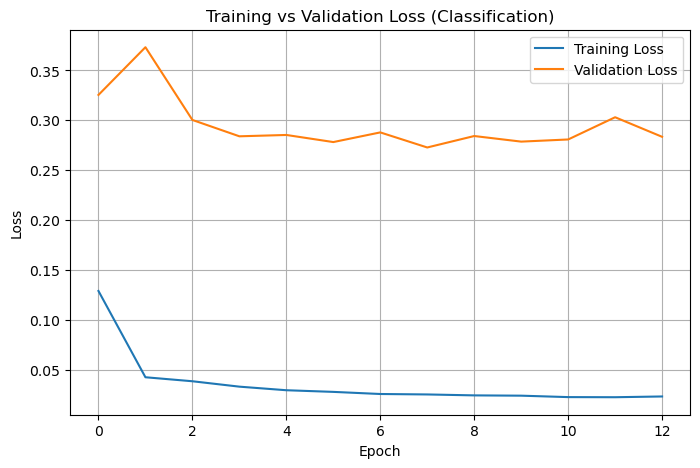

In [33]:
import matplotlib.pyplot as plt

# --- Plot training & validation loss
plt.figure(figsize=(8,5))
plt.plot(history_bin.history['loss'], label='Training Loss')
plt.plot(history_bin.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss (Classification)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


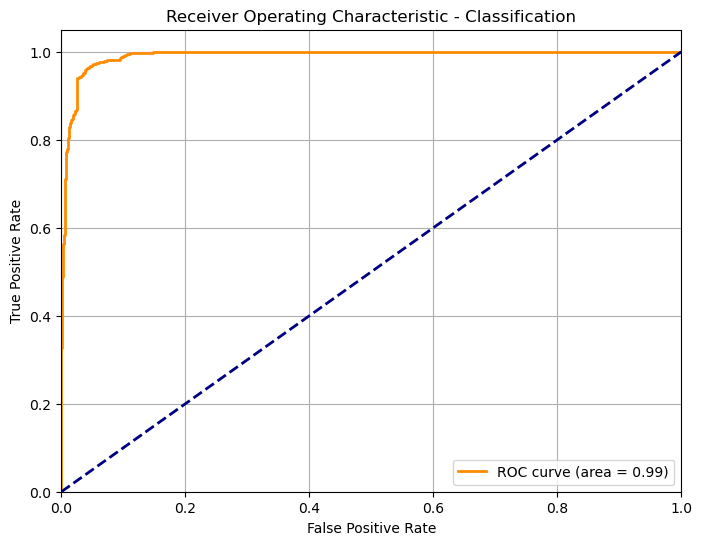

In [34]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Classification')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [37]:
# Features to use for forecasting (NO current Available_Connectors or Busy_Connectors)
features_forecast = [
    'Latitude', 'Longitude', 'Power_kW',
    'hour_sin', 'hour_cos',
    'DayOfWeek', 'IsWeekend'
] + \
[col for col in df.columns if col.startswith('Connector_Type_')] + \
[col for col in df.columns if col.startswith('Name_')]

# Important: No "Available_Connectors" or "Busy_Connectors" or "lag_15min" etc. as input.

def create_forecast_sequences(data, seq_len, features, target_col):
    X, y = [], []
    arr = data[features].values
    targets = data[target_col].values
    for i in range(seq_len, len(data)):
        X.append(arr[i - seq_len:i])
        y.append(targets[i])  # Target at time i
    return np.array(X), np.array(y)

# Example
seq_len = 12  # e.g., 1 hour past data (if 5-min intervals)
target_col = 'Available_Connectors'

# Sort data
df_sorted = df.sort_values(['Charger_ID', 'Timestamp'])

X_forecast, y_forecast = create_forecast_sequences(
    df_sorted, seq_len, features_forecast, target_col
)

print("X shape:", X_forecast.shape)
print("y shape:", y_forecast.shape)


df['Date'] = df['Timestamp'].dt.date
split_date = pd.to_datetime('2025-04-30').date()

train_df = df[df['Date'] < split_date]
test_df = df[df['Date'] == split_date]

# Create sequences for both
X_train_forecast, y_train_forecast = create_forecast_sequences(
    train_df.sort_values(['Charger_ID', 'Timestamp']),
    seq_len,
    features_forecast,
    target_col
)

X_test_forecast, y_test_forecast = create_forecast_sequences(
    test_df.sort_values(['Charger_ID', 'Timestamp']),
    seq_len,
    features_forecast,
    target_col
)


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def build_forecasting_model(seq_len, n_features, lstm_units=64, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(lstm_units, input_shape=(seq_len, n_features)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='linear'))  # For regression output
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    return model

n_features_forecast = len(features_forecast)

model_forecast = build_forecasting_model(seq_len, n_features_forecast)
model_forecast.summary()

# --- FIX DATA TYPES to avoid TensorFlow errors ---
X_train_forecast = X_train_forecast.astype(np.float32)
y_train_forecast = y_train_forecast.astype(np.float32)

from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model_forecast.fit(
    X_train_forecast, y_train_forecast,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=[es]
)

X_test_forecast = X_test_forecast.astype(np.float32)
y_test_forecast = y_test_forecast.astype(np.float32)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred_forecast = model_forecast.predict(X_test_forecast).ravel()

mae = mean_absolute_error(y_test_forecast, y_pred_forecast)
rmse = np.sqrt(mean_squared_error(y_test_forecast, y_pred_forecast))
r2 = r2_score(y_test_forecast, y_pred_forecast)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.2f}")




X shape: (11500, 12, 10)
y shape: (11500,)
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 64)                19200     
                                                                 
 dropout_21 (Dropout)        (None, 64)                0         
                                                                 
 dense_21 (Dense)            (None, 1)                 65        
                                                                 
Total params: 19,265
Trainable params: 19,265
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
96/96 [==============================] - 3s 20ms/step - loss: 5.4832 - mae: 1.6394 - val_loss: 9.5875 - val_mae: 2.5215
Epoch 2/50
96/96 [==============================] - 2s 16ms/step - loss: 1.4202 - mae: 0.7359 - val_loss: 22.9145 - val_mae: 3.8210
Epoch 3

In [38]:
# --- Features stay exactly the same ---
features_forecast = [
    'Latitude', 'Longitude', 'Power_kW',
    'hour_sin', 'hour_cos',
    'DayOfWeek', 'IsWeekend'
] + \
[col for col in df.columns if col.startswith('Connector_Type_')] + \
[col for col in df.columns if col.startswith('Name_')]

# --- Target for classification ---
target_col_classification = 'Is_Available'

# --- Sequence creation function ---
def create_forecast_sequences(data, seq_len, features, target_col):
    X, y = [], []
    arr = data[features].values
    targets = data[target_col].values
    for i in range(seq_len, len(data)):
        X.append(arr[i - seq_len:i])
        y.append(targets[i])  # Target at time i
    return np.array(X), np.array(y)

# --- Sequence length ---
seq_len = 12  # 1 hour history

# --- Sort data ---
df_sorted = df.sort_values(['Charger_ID', 'Timestamp'])

# --- Create sequences for entire dataset (optional, just to check shapes) ---
X_forecast_class, y_forecast_class = create_forecast_sequences(
    df_sorted, seq_len, features_forecast, target_col_classification
)

print("X shape (classification):", X_forecast_class.shape)
print("y shape (classification):", y_forecast_class.shape)

# --- Train/Test split based on date ---
df['Date'] = df['Timestamp'].dt.date
split_date = pd.to_datetime('2025-04-30').date()

train_df = df[df['Date'] < split_date]
test_df = df[df['Date'] == split_date]

# --- Create TRAIN sequences ---
X_train_class, y_train_class = create_forecast_sequences(
    train_df.sort_values(['Charger_ID', 'Timestamp']),
    seq_len,
    features_forecast,
    target_col_classification
)

# --- Create TEST sequences ---
X_test_class, y_test_class = create_forecast_sequences(
    test_df.sort_values(['Charger_ID', 'Timestamp']),
    seq_len,
    features_forecast,
    target_col_classification
)

# --- Fix data types (AVOID TensorFlow errors) ---
X_train_class = X_train_class.astype(np.float32)
y_train_class = y_train_class.astype(np.float32)
X_test_class = X_test_class.astype(np.float32)
y_test_class = y_test_class.astype(np.float32)

# --- Build CLASSIFICATION model ---
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def build_classification_forecast_model(seq_len, n_features, lstm_units=64, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(lstm_units, input_shape=(seq_len, n_features)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Classification → sigmoid
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

n_features_forecast = len(features_forecast)

model_class = build_classification_forecast_model(seq_len, n_features_forecast)
model_class.summary()

# --- Train ---
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_class = model_class.fit(
    X_train_class, y_train_class,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=[es]
)

# --- Evaluate ---
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

y_pred_prob_class = model_class.predict(X_test_class).ravel()
y_pred_class = (y_pred_prob_class > 0.5).astype(int)

print("\n🔎 Classification Metrics (Test Set):")
print("Accuracy:", accuracy_score(y_test_class, y_pred_class))
print("Precision:", precision_score(y_test_class, y_pred_class))
print("Recall:", recall_score(y_test_class, y_pred_class))
print("F1 Score:", f1_score(y_test_class, y_pred_class))
print("ROC-AUC:", roc_auc_score(y_test_class, y_pred_prob_class))

print("\nConfusion Matrix:\n", confusion_matrix(y_test_class, y_pred_class))
print("\nClassification Report:\n", classification_report(y_test_class, y_pred_class))


X shape (classification): (11500, 12, 10)
y shape (classification): (11500,)
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 64)                19200     
                                                                 
 dropout_22 (Dropout)        (None, 64)                0         
                                                                 
 dense_22 (Dense)            (None, 1)                 65        
                                                                 
Total params: 19,265
Trainable params: 19,265
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
96/96 [==============================] - 5s 24ms/step - loss: 0.4239 - accuracy: 0.7730 - val_loss: 0.8052 - val_accuracy: 0.7454
Epoch 2/50
96/96 [==============================] - 2s 20ms/step - loss: 0.1208 - accuracy: 0.9

In [39]:
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

param_grid = {
    'seq_len': [6, 12, 18],              # 30min, 60min, 90min sequences
    'lstm_units': [32, 64, 128],
    'dropout_rate': [0.1, 0.2, 0.3],
    'batch_size': [32, 64]
}

best_score = None
best_params = None

n_features_forecast = len(features_forecast)

print("🔎 Starting hyperparameter search...")

for params in ParameterGrid(param_grid):

    print(f"\n🔍 Trying params: {params}")

    # --- Recreate sequences for this seq_len ---
    X_train_cls, y_train_cls = create_forecast_sequences(
        train_df.sort_values(['Charger_ID', 'Timestamp']),
        params['seq_len'],
        features_forecast,
        'Is_Available'   # Classification target
    )

    # Convert data types
    X_train_cls = X_train_cls.astype(np.float32)
    y_train_cls = y_train_cls.astype(np.float32)

    # Train/validation split (80/20)
    split = int(0.8 * len(X_train_cls))
    X_tr, X_val = X_train_cls[:split], X_train_cls[split:]
    y_tr, y_val = y_train_cls[:split], y_train_cls[split:]

    # --- Build model ---
    model = Sequential()
    model.add(LSTM(params['lstm_units'], input_shape=(params['seq_len'], n_features_forecast)))
    model.add(Dropout(params['dropout_rate']))
    model.add(Dense(1, activation='sigmoid'))  # Classification output
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # --- Train ---
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        X_tr, y_tr,
        validation_data=(X_val, y_val),
        epochs=30,
        batch_size=params['batch_size'],
        verbose=0,
        callbacks=[es]
    )

    # --- Validation metrics ---
    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
    print(f"Validation Accuracy: {val_acc:.4f}")

    # Save best
    if best_score is None or val_acc > best_score:
        best_score = val_acc
        best_params = params

print("\n✅ Best hyperparameters found:")
print("Params:", best_params)
print("Validation accuracy:", best_score)


🔎 Starting hyperparameter search...

🔍 Trying params: {'batch_size': 32, 'dropout_rate': 0.1, 'lstm_units': 32, 'seq_len': 6}
Validation Accuracy: 0.7450

🔍 Trying params: {'batch_size': 32, 'dropout_rate': 0.1, 'lstm_units': 32, 'seq_len': 12}
Validation Accuracy: 0.7454

🔍 Trying params: {'batch_size': 32, 'dropout_rate': 0.1, 'lstm_units': 32, 'seq_len': 18}
Validation Accuracy: 0.7595

🔍 Trying params: {'batch_size': 32, 'dropout_rate': 0.1, 'lstm_units': 64, 'seq_len': 6}
Validation Accuracy: 0.7450

🔍 Trying params: {'batch_size': 32, 'dropout_rate': 0.1, 'lstm_units': 64, 'seq_len': 12}
Validation Accuracy: 0.7454

🔍 Trying params: {'batch_size': 32, 'dropout_rate': 0.1, 'lstm_units': 64, 'seq_len': 18}
Validation Accuracy: 0.7464

🔍 Trying params: {'batch_size': 32, 'dropout_rate': 0.1, 'lstm_units': 128, 'seq_len': 6}
Validation Accuracy: 0.7450

🔍 Trying params: {'batch_size': 32, 'dropout_rate': 0.1, 'lstm_units': 128, 'seq_len': 12}
Validation Accuracy: 0.7526

🔍 Trying par

In [42]:
# Use best sequence length from hyperparameter tuning
final_seq_len = best_params['seq_len']

# Create training sequences
X_train_final, y_train_final = create_forecast_sequences(
    train_df.sort_values(['Charger_ID', 'Timestamp']),
    final_seq_len,
    features_forecast,
    'Is_Available'
)

# Create test sequences
X_test_final, y_test_final = create_forecast_sequences(
    test_df.sort_values(['Charger_ID', 'Timestamp']),
    final_seq_len,
    features_forecast,
    'Is_Available'
)

# Check shapes
print("X_train_final shape:", X_train_final.shape)
print("X_test_final shape:", X_test_final.shape)

# Fix data types
X_train_final = X_train_final.astype(np.float32)
y_train_final = y_train_final.astype(np.float32)
X_test_final = X_test_final.astype(np.float32)
y_test_final = y_test_final.astype(np.float32)


X_train_final shape: (7670, 18, 10)
X_test_final shape: (2198, 18, 10)


In [43]:
# Build final classification model
final_model = Sequential()
final_model.add(LSTM(best_params['lstm_units'], input_shape=(final_seq_len, len(features_forecast))))
final_model.add(Dropout(best_params['dropout_rate']))
final_model.add(Dense(1, activation='sigmoid'))  # Binary output for availability

final_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

final_model.summary()


Model: "sequential_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_77 (LSTM)              (None, 64)                19200     
                                                                 
 dropout_77 (Dropout)        (None, 64)                0         
                                                                 
 dense_77 (Dense)            (None, 1)                 65        
                                                                 
Total params: 19,265
Trainable params: 19,265
Non-trainable params: 0
_________________________________________________________________


In [44]:
from tensorflow.keras.callbacks import EarlyStopping

es_final = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_final = final_model.fit(
    X_train_final, y_train_final,
    validation_split=0.2,
    epochs=50,
    batch_size=best_params['batch_size'],
    callbacks=[es_final]
)


Epoch 1/50
96/96 [==============================] - 4s 29ms/step - loss: 0.3728 - accuracy: 0.8198 - val_loss: 0.9842 - val_accuracy: 0.7568
Epoch 2/50
96/96 [==============================] - 2s 20ms/step - loss: 0.1054 - accuracy: 0.9672 - val_loss: 1.0365 - val_accuracy: 0.7595
Epoch 3/50
96/96 [==============================] - 2s 20ms/step - loss: 0.0830 - accuracy: 0.9749 - val_loss: 1.1045 - val_accuracy: 0.7595
Epoch 4/50
96/96 [==============================] - 2s 18ms/step - loss: 0.0647 - accuracy: 0.9801 - val_loss: 1.3215 - val_accuracy: 0.7595
Epoch 5/50
96/96 [==============================] - 2s 20ms/step - loss: 0.0571 - accuracy: 0.9845 - val_loss: 1.3397 - val_accuracy: 0.7614
Epoch 6/50
96/96 [==============================] - 2s 18ms/step - loss: 0.0576 - accuracy: 0.9819 - val_loss: 1.3258 - val_accuracy: 0.7523


In [45]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# --- Predictions ---
y_pred_prob_final = final_model.predict(X_test_final).ravel()
y_pred_final = (y_pred_prob_final > 0.5).astype(int)

# --- Metrics ---
print("\n🔎 Final Classification Metrics (Test Set):")
print("Accuracy:", accuracy_score(y_test_final, y_pred_final))
print("Precision:", precision_score(y_test_final, y_pred_final))
print("Recall:", recall_score(y_test_final, y_pred_final))
print("F1 Score:", f1_score(y_test_final, y_pred_final))
print("ROC-AUC:", roc_auc_score(y_test_final, y_pred_prob_final))

print("\nConfusion Matrix:\n", confusion_matrix(y_test_final, y_pred_final))

print("\nClassification Report:\n", classification_report(y_test_final, y_pred_final))


69/69 [==============================] - 1s 8ms/step

🔎 Final Classification Metrics (Test Set):
Accuracy: 0.9253867151956324
Precision: 0.8864468864468864
Recall: 0.992616899097621
F1 Score: 0.9365325077399381
ROC-AUC: 0.9172851371835619

Confusion Matrix:
 [[ 824  155]
 [   9 1210]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.84      0.91       979
         1.0       0.89      0.99      0.94      1219

    accuracy                           0.93      2198
   macro avg       0.94      0.92      0.92      2198
weighted avg       0.93      0.93      0.92      2198



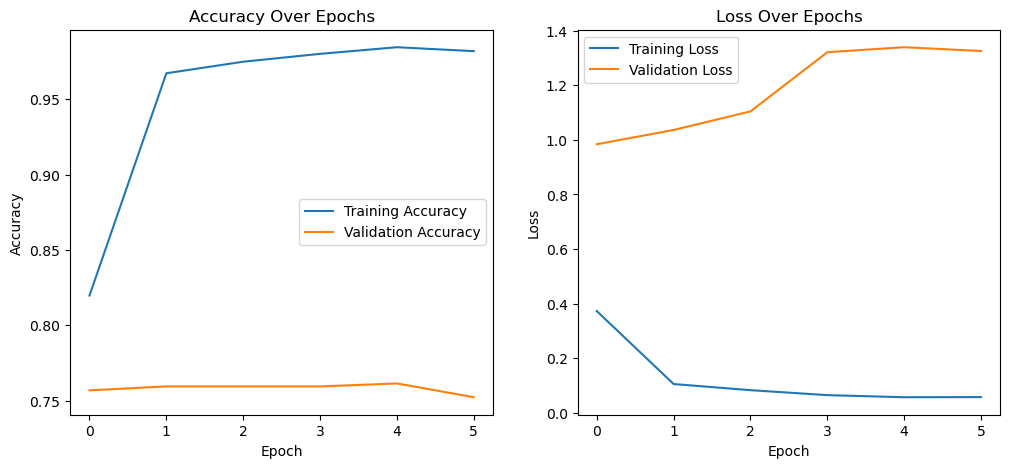

In [46]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history_final.history['accuracy'], label='Training Accuracy')
plt.plot(history_final.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1,2,2)
plt.plot(history_final.history['loss'], label='Training Loss')
plt.plot(history_final.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [63]:

from sklearn.utils import class_weight

# Compute new class weights based on training labels
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train_final),
    y=y_train_final
)
class_weights = dict(enumerate(class_weights))
print("Updated Class Weights:", class_weights)


# 2️⃣ Rebuild the model (same best params found earlier)
model_final = Sequential()
model_final.add(LSTM(64, input_shape=(18, 10)))  # best lstm_units=64, seq_len=18
model_final.add(Dropout(0.1))
model_final.add(Dense(1, activation='sigmoid'))
model_final.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 3️⃣ Train with class weights
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model_final.fit(
    X_train_final, y_train_final,
    validation_split=0.2,
    epochs=50,
    batch_size=64,  # best batch size found
    callbacks=[es],
    class_weight=class_weights  # ⭐ This is the important fix!
)

# 4️⃣ Evaluate on test set
y_test_probs = model_final.predict(X_test_final).ravel()

# Optionally, set a higher threshold if needed:
threshold = 0.7  # Try stricter decision boundary
y_test_pred = (y_test_probs > threshold).astype(int)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

print("\n🔎 Final Classification Metrics (Test Set):")
print("Accuracy:", accuracy_score(y_test_final, y_test_pred))
print("Precision:", precision_score(y_test_final, y_test_pred))
print("Recall:", recall_score(y_test_final, y_test_pred))
print("F1 Score:", f1_score(y_test_final, y_test_pred))
print("ROC-AUC:", roc_auc_score(y_test_final, y_test_probs))

print("\nConfusion Matrix:\n", confusion_matrix(y_test_final, y_test_pred))

print("\nClassification Report:\n", classification_report(y_test_final, y_test_pred))


Updated Class Weights: {0: 1.1906240298044086, 1: 0.8619914587547763}
Epoch 1/50
96/96 [==============================] - 4s 29ms/step - loss: 0.4037 - accuracy: 0.7894 - val_loss: 0.6157 - val_accuracy: 0.7464
Epoch 2/50
96/96 [==============================] - 2s 24ms/step - loss: 0.1377 - accuracy: 0.9553 - val_loss: 0.9658 - val_accuracy: 0.7497
Epoch 3/50
96/96 [==============================] - 2s 21ms/step - loss: 0.0981 - accuracy: 0.9715 - val_loss: 1.0053 - val_accuracy: 0.7595
Epoch 4/50
96/96 [==============================] - 2s 20ms/step - loss: 0.0808 - accuracy: 0.9747 - val_loss: 1.0745 - val_accuracy: 0.7484
Epoch 5/50
96/96 [==============================] - 2s 20ms/step - loss: 0.0656 - accuracy: 0.9826 - val_loss: 1.0979 - val_accuracy: 0.7608
Epoch 6/50
69/69 [==============================] - 1s 8ms/step

🔎 Final Classification Metrics (Test Set):
Accuracy: 0.8712465878070974
Precision: 0.8471810089020771
Recall: 0.9368334700574241
F1 Score: 0.8897545773276198
RO

In [48]:
import requests
import pandas as pd
from datetime import datetime
import time

# --- CONFIGURATION ---
API_KEY = "xwG3dZUx5dMlrHyt7rEY8gRHEBZ1Z3Dp"
BASE_URL = "https://api.tomtom.com"
LAT, LON = -37.8136, 144.9631  # Melbourne CBD
RADIUS = 100000  # in meters

# --- 1. FETCH CHARGING STATIONS FROM SEARCH API ---
def fetch_charging_stations(lat, lon, radius, api_key):
    url = f"{BASE_URL}/search/2/categorySearch/charging station.json"
    params = {
        "key": api_key,
        "lat": lat,
        "lon": lon,
        "radius": radius,
        "categorySet": "7309",  # Charging stations
        "limit": 50  # You can increase or page over results
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        stations = []
        for result in data.get("results", []):
            station = {
                "Name": result.get("poi", {}).get("name"),
                "Charger_ID": result.get("dataSources", {}).get("chargingAvailability", {}).get("id"),
                "Latitude": result.get("position", {}).get("lat"),
                "Longitude": result.get("position", {}).get("lon")
            }
            if station["Charger_ID"]:
                stations.append(station)
        return stations
    else:
        print(f"Search API Error: {response.status_code} - {response.text}")
        return []

# --- 2. GET AVAILABILITY DETAILS ---
def fetch_availability(charger_id, api_key):
    url = f"{BASE_URL}/search/2/chargingAvailability.json"
    params = {
        "key": api_key,
        "chargingAvailability": charger_id
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        if "connectors" in data and len(data["connectors"]) > 0:
            conn = data["connectors"][0]
            return {
                "Status": "Available",
                "Available_Connectors": conn["availability"]["current"].get("available", 0),
                "Busy_Connectors": conn["availability"]["current"].get("occupied", 0),
                "Power_kW": conn.get("availability", {}).get("perPowerLevel", [{}])[0].get("powerKW", "N/A"),
                "Connector_Type": conn.get("type", "N/A")
            }
        else:
            return {
                "Status": "Unknown",
                "Available_Connectors": "N/A",
                "Busy_Connectors": "N/A",
                "Power_kW": "N/A",
                "Connector_Type": "N/A"
            }
    else:
        print(f"Availability API Error for {charger_id}: {response.status_code} - {response.text}")
        return {
            "Status": "Error",
            "Available_Connectors": "N/A",
            "Busy_Connectors": "N/A",
            "Power_kW": "N/A",
            "Connector_Type": "N/A"
        }

# --- 3. MAIN SCRIPT ---
stations = fetch_charging_stations(LAT, LON, RADIUS, API_KEY)
final_data = []

for station in stations:
    availability = fetch_availability(station["Charger_ID"], API_KEY)
    combined = {
        **station,
        **availability,
        "Timestamp": datetime.utcnow().isoformat()
    }
    final_data.append(combined)
    time.sleep(1)  # avoid exceeding rate limits

df1 = pd.DataFrame(final_data)
print(df1)


                             Name                            Charger_ID  \
0                       ChargeFox  291f046e-463c-46a4-8ce6-26d113469971   
1                       ChargeFox  49293063-d71c-4093-b273-0cb3401a1056   
2                        Exploren  6f2732e0-29e7-4dbc-a804-5544773beeed   
3                        Exploren  e038a32a-5442-4218-b3b3-ca08ec135dec   
4                       ChargeFox  00887bb2-1a22-4369-bc62-bd037695d12f   
5   Saascharge International GmbH  83188e00-c87d-4c1c-9b0c-5153eb100563   
6                       ChargeFox  fcb1d2d5-32a5-4f09-9202-455bdcab0a1e   
7                            Evie  de51892d-e7e0-425a-905e-8d0f786afc34   
8                       ChargeFox  abe54361-ca03-4816-b183-77dcb1a55b0e   
9                            Evie  6a5f5176-ff0a-4dac-ad74-746f59cd23ce   
10                       Exploren  b2b4233f-cfa0-4004-8841-b735695470cb   
11                      ChargeFox  339fcea1-1f13-494d-afb6-3e1328dff60e   
12                      C

In [52]:
df.to_csv("availability_test.csv", index=False)
df = pd.read_csv('availability_test.csv', parse_dates=['Timestamp'])

In [54]:
df = df.sort_values(by=['Charger_ID', 'Timestamp']).reset_index(drop=True)

# Lag features (1 time step back)
df['Available_Lag1'] = df.groupby('Charger_ID')['Available_Connectors'].shift(1).fillna(0)
df['Busy_Lag1'] = df.groupby('Charger_ID')['Busy_Connectors'].shift(1).fillna(0)

# --- 2. Create binary target for classification ---
df['Is_Available'] = (df['Available_Connectors'] > 0).astype(int)

# --- 3. Feature engineering: time-based features ---
df['hour'] = df['Timestamp'].dt.hour
df['dayofweek'] = df['Timestamp'].dt.dayofweek

# Cyclical encoding for hour
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

# --- 4. Lag features (keep your existing ones and add more) ---
df = df.sort_values(['Charger_ID', 'Timestamp'])
df['lag_15min'] = df.groupby('Charger_ID')['Is_Available'].shift(3)
df['lag_30min'] = df.groupby('Charger_ID')['Is_Available'].shift(6)

# If any lag is missing (start of series), fill with previous lag or 0
df['lag_15min'] = df['lag_15min'].fillna(df['Available_Lag1']).fillna(0)
df['lag_30min'] = df['lag_30min'].fillna(df['Available_Lag1']).fillna(0)

# --- 5. Impute missing only if needed ---
# We only impute if missing. If Power_kW and Busy/Available are present, keep original.
imputer = SimpleImputer(strategy='median')

for col in ['Latitude', 'Longitude']:
    if df[col].isnull().sum() > 0:
        df[col] = imputer.fit_transform(df[[col]])

# Do not impute Power_kW if the values are valid (you provided them in a previous phase)
if df['Power_kW'].isnull().sum() > 0:
    df['Power_kW'] = imputer.fit_transform(df[['Power_kW']])

# --- 6. Scaling numeric features (only continuous values) ---
scaler = StandardScaler()

df[['Latitude', 'Longitude', 'Power_kW']] = scaler.fit_transform(
    df[['Latitude', 'Longitude', 'Power_kW']]
)

# --- 7. Encoding categorical while keeping original names for interpretability ---

# One-hot encode Connector_Type but retain original column
df = pd.get_dummies(df, columns=['Connector_Type'], drop_first=True)

In [55]:
import pandas as pd
import numpy as np
from math import sin, cos, pi

# Assuming df_api is your new API dataframe

df_api = df

# --- Temporal features ---
df_api['Timestamp'] = pd.to_datetime(df_api['Timestamp'])
df_api['hour'] = df_api['Timestamp'].dt.hour + df_api['Timestamp'].dt.minute / 60
df_api['hour_sin'] = np.sin(2 * pi * df_api['hour'] / 24)
df_api['hour_cos'] = np.cos(2 * pi * df_api['hour'] / 24)
df_api['DayOfWeek'] = df_api['Timestamp'].dt.dayofweek
df_api['IsWeekend'] = df_api['DayOfWeek'].isin([5, 6]).astype(int)

# Drop 'hour' column (no longer needed)
df_api.drop('hour', axis=1, inplace=True)


In [57]:
seq_len = 18  # From your best hyperparameters

X_api = []

for idx, row in df_api.iterrows():
    # Extract features for this row
    row_data = row[features_forecast].values.astype(np.float32)
    # Repeat it seq_len times to form a sequence
    sequence = np.tile(row_data, (seq_len, 1))
    X_api.append(sequence)

X_api = np.array(X_api)

print("API input shape for model:", X_api.shape)


API input shape for model: (16, 18, 10)


In [83]:
# Predict probabilities instead of direct classes
y_prob = model.predict(X_api).ravel()

# Use a higher threshold than default 0.5
threshold = 0.6
y_pred_api = (y_prob >= threshold).astype(int)

# Add predictions back to your dataframe
df_api['Predicted_Available'] = y_pred_api


print(df_api[['Charger_ID', 'Predicted_Available']])


AttributeError: 'TransformerClassifier' object has no attribute 'predict'

In [36]:
# -------------------------------------------------------------
# 0. Imports
# -------------------------------------------------------------
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from datetime import datetime


##############################################################################
# 0.  Parameters that control the horizon
##############################################################################
SEQ_LEN        = 12            # 60‑min history (6 → 30 min history etc.)
STEP_MIN       = 5             # your sampling interval
OFFSETS        = [1, 3, 6]     # ❶ 5‑, 15‑, 30‑minute look‑ahead
N_HORIZONS     = len(OFFSETS)  # = 3
THRESHOLD      = 0.6           # apply per horizon later
##############################################################################

# -------------------------------------------------------------
# 1. Load your pre‑processed dataframe
#     (the one that already has hour_sin/hour_cos, lag_15min, etc.)
# -------------------------------------------------------------

# -------------------------------------------------------------
# 2. Drop leakage columns
# -------------------------------------------------------------
cols_to_drop = ["Available_Connectors", "Busy_Connectors", "Status"]
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

# -------------------------------------------------------------
# 3. Encode operator (Name) as integer IDs
#    – keep the mapping for an nn.Embedding later
# -------------------------------------------------------------
operator2id = {name: idx for idx, name in enumerate(df["Name"].unique())}
df["OperatorID"] = df["Name"].map(operator2id)
operator_vocab_size = len(operator2id)

# -------------------------------------------------------------
# 4. Select feature columns
# -------------------------------------------------------------
numeric_cols = ["Latitude", "Longitude", "Power_kW"]
time_cols    = ["hour_sin", "hour_cos", "DayOfWeek", "IsWeekend"]
lag_cols     = [c for c in df.columns if c.startswith("lag_")]
connector_cols = [c for c in df.columns if c.startswith("Connector_Type_")]

feature_cols = numeric_cols + time_cols + lag_cols + connector_cols + ["OperatorID"]

# -------------------------------------------------------------
# 5. Fit a scaler **only on numeric columns** of the training period
#    (here we hold out the very last day for test)
# -------------------------------------------------------------
df["Date"] = df["Timestamp"].dt.date
split_date = pd.to_datetime("2025-04-30").date()       # last day = test

train_df   = df[df["Date"] < split_date].copy()
test_df    = df[df["Date"] == split_date].copy()

scaler = StandardScaler().fit(train_df[numeric_cols])
train_df[numeric_cols] = scaler.transform(train_df[numeric_cols])
test_df[numeric_cols]  = scaler.transform(test_df[numeric_cols])

# -------------------------------------------------------------
# 6. Sequence‑window function
# -------------------------------------------------------------
### NEW / CHANGED ############################################################
def build_sequences(dataframe, seq_len=SEQ_LEN, offsets=OFFSETS):
    """
    Multi‑horizon version.
    • X  → (N, seq_len, F)
    • y  → (N, N_HORIZONS)  with binary 0/1 labels
    """
    X, y = [], []
    dataframe = dataframe.sort_values(["Charger_ID", "Timestamp"])
    for _, grp in dataframe.groupby("Charger_ID"):
        feat   = grp[feature_cols].values.astype(np.float32)
        labels = grp["Is_Available"].values.astype(np.float32)
        T      = len(grp)
        last   = seq_len + max(offsets) - 1
        for i in range(T - last):
            X.append(feat[i : i + seq_len])
            # one label per horizon
            y.append([labels[i + seq_len + o - 1] for o in offsets])
    return np.stack(X), np.stack(y).astype(np.float32)
##############################################################################
# -------------------------------------------------------------
# rebuild X / y with the *multi‑horizon* helper
# -------------------------------------------------------------
X_train_full, y_train_full = build_sequences(
    train_df, seq_len=SEQ_LEN, offsets=OFFSETS
)
X_test, y_test = build_sequences(
    test_df, seq_len=SEQ_LEN, offsets=OFFSETS
)

print("Shapes  –  X:", X_train_full.shape, " y:", y_train_full.shape)  
# expected →  (N, 12, 13)  (N, 3)
# 👇 Add this after build_sequences() call
charger_ids_seq = []

# This will keep track of which charger each sequence in X_test belongs to
for cid, group in test_df.groupby("Charger_ID"):
    T = len(group)
    last = SEQ_LEN + max(OFFSETS) - 1
    for i in range(T - last):
        charger_ids_seq.append(cid)

import joblib
joblib.dump(charger_ids_seq, "charger_ids_seq.pkl")
print("✅ Saved charger_ids_seq for Streamlit.")

# -------------------------------------------------------------
# 7. Split train_full → train / val (time‑aware split, last 10 % for val)
# -------------------------------------------------------------
N = len(X_train_full)
val_pct = 0.10
split_idx = int(N * (1 - val_pct))

X_train, y_train = X_train_full[:split_idx], y_train_full[:split_idx]
X_val,   y_val   = X_train_full[split_idx:], y_train_full[split_idx:]

print("👉 Sequence shapes:")
print("  X_train:", X_train.shape, "y_train:", y_train.shape)
print("  X_val  :", X_val.shape,   "y_val  :", y_val.shape)
print("  X_test :", X_test.shape,  "y_test :", y_test.shape)

num_features = X_train.shape[-1]

# -------------------------------------------------------------
# 8. Optional: class‑imbalance weights  (multi‑label version)
# -------------------------------------------------------------
#
# y_train is (N, 3)  →  one column per horizon
# For each horizon h compute:
#     pos_weight_h =  ( #negative / #positive )
# BCEWithLogitsLoss will then multiply the loss
# of positive examples by that factor.

# prevalence (fraction of 1‑labels) for each horizon
pos_frac   = y_train.mean(axis=0)          # shape (3,)
# avoid division by zero in case a horizon is all zeros
pos_frac   = np.clip(pos_frac, 1e-6, 1 - 1e-6)

pos_weight = (1.0 - pos_frac) / pos_frac   # shape (3,)
print("Per‑horizon positive fractions :", pos_frac.round(3).tolist())
print("Per‑horizon pos_weight factors :", pos_weight.round(2).tolist())

# turn into a torch tensor so BCEWithLogitsLoss can use it
pos_weight = torch.from_numpy(pos_weight).float()      # (3,)


Shapes  –  X: (7552, 12, 13)  y: (7552, 3)
✅ Saved charger_ids_seq for Streamlit.
👉 Sequence shapes:
  X_train: (6796, 12, 13) y_train: (6796, 3)
  X_val  : (756, 12, 13) y_val  : (756, 3)
  X_test : (2080, 12, 13) y_test : (2080, 3)
Per‑horizon positive fractions : [0.5600000023841858, 0.5590000152587891, 0.5580000281333923]
Per‑horizon pos_weight factors : [0.7900000214576721, 0.7900000214576721, 0.7900000214576721]


In [7]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset

class EVChargerDataset(Dataset):
    """
    PyTorch Dataset for EV charger time-series data.
    Each sample is a sequence of past timesteps (seq_len x features) and a binary label.
    """
    def __init__(self, dataframe: pd.DataFrame, seq_len: int = 12):
        """
        dataframe: Pandas DataFrame containing sorted time-series data.
        Required columns: all feature columns + 'Is_Available', 'StationID'.
        seq_len: number of past intervals to use (e.g., 12 for 1 hour at 5-min steps).
        """
        self.seq_len = seq_len
        self.samples = []
        # Ensure data is sorted by StationID and timestamp
        dataframe = dataframe.sort_values(['StationID','timestamp'])
        
        # Group by station to create sequences for each charger
        for station_id, group in dataframe.groupby('StationID'):
            group = group.reset_index(drop=True)
            features = ['Latitude', 'Longitude', 'Power_kW', 'hour_sin', 'hour_cos',
                        'DayOfWeek', 'IsWeekend'] + \
                       [col for col in dataframe.columns if col.startswith('Connector_')] + \
                       [col for col in dataframe.columns if col.startswith('lag_')]
            X_all = group[features].values
            y_all = group['Is_Available'].values
            # Slide over time to create (seq_len -> label) samples
            for i in range(len(group) - seq_len):
                x_seq = X_all[i:i+seq_len]
                y_label = y_all[i+seq_len]  # predict next step availability
                self.samples.append((x_seq.astype(np.float32), np.float32(y_label)))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        X_seq, y = self.samples[idx]
        # Convert to tensors
        return torch.from_numpy(X_seq), torch.tensor(y)


In [8]:
import torch.nn as nn

### NEW / CHANGED ############################################################
class TransformerClassifier(nn.Module):
    def __init__(self, num_features, d_model=64, n_heads=4,
                 n_layers=2, dropout=0.1, n_out=N_HORIZONS):
        super().__init__()
        self.input_fc  = nn.Linear(num_features, d_model)
        enc_layer      = nn.TransformerEncoderLayer(
                            d_model=d_model, nhead=n_heads,
                            dropout=dropout, batch_first=True)
        self.encoder   = nn.TransformerEncoder(enc_layer, num_layers=n_layers)
        self.pool      = nn.AdaptiveAvgPool1d(1)
        self.classifier= nn.Linear(d_model, n_out)   # <‑‑ 3 logits
    def forward(self, x):
        x = self.input_fc(x)
        x = self.encoder(x)
        x = self.pool(x.permute(0,2,1)).squeeze(-1)
        return self.classifier(x)      # (batch, 3) – no sigmoid
##############################################################################


In [14]:
##############################################################################
# 0.  Parameters that control the horizon
##############################################################################
SEQ_LEN        = 12            # 60‑min history (6 → 30 min history etc.)
STEP_MIN       = 5             # your sampling interval
OFFSETS        = [1, 3, 6]     # ❶ 5‑, 15‑, 30‑minute look‑ahead
N_HORIZONS     = len(OFFSETS)  # = 3
THRESHOLD      = 0.6           # apply per horizon later
BATCH_SIZE = 64  # or 32 or whatever batch size you want to use
D_MODEL    = 64
N_HEADS    = 4
N_LAYERS   = 2
DROPOUT    = 0.1
LR = 1e-3  # or any learning rate you choose, like 3e-4, 5e-4, etc.
NUM_EPOCHS = 30
PATIENCE = 5  # also needed for early stopping

##############################################################################


##############################################################################
# 1.  PyTorch DataLoaders (uses the pre‑built arrays)
##############################################################################
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

def to_loader(X, y, shuffle, bs=BATCH_SIZE):
    ds = TensorDataset(torch.tensor(X, dtype=torch.float32),
                       torch.tensor(y, dtype=torch.float32))
    sampler = RandomSampler(ds) if shuffle else SequentialSampler(ds)
    return DataLoader(ds, sampler=sampler, batch_size=bs, drop_last=False)


train_loader = to_loader(X_train, y_train, shuffle=True)
val_loader   = to_loader(X_val,   y_val,   shuffle=False)
test_loader  = to_loader(X_test,  y_test,  shuffle=False)

##############################################################################
# 2.  Model / loss / optimizer
##############################################################################
import torch.nn as nn
import torch.optim as optim

model = TransformerClassifier(num_features=num_features,
                              d_model=D_MODEL,
                              n_heads=N_HEADS,
                              n_layers=N_LAYERS,
                              dropout=DROPOUT)

### NEW / CHANGED ############################################################
# one pos_weight per horizon (optional – keep the same ratio for all)

criterion  = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
##############################################################################

optimizer  = optim.Adam(model.parameters(), lr=LR)

##############################################################################
# 3.  Train with early‑stopping
##############################################################################
best_val_f1, no_improve = 0.0, 0

for epoch in range(1, NUM_EPOCHS + 1):
    # ---- training ----
    model.train(); train_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        logits = model(xb)                 # ← keep shape (bs, 3)
        loss   = criterion(logits, yb)     # ← NO .squeeze() anywhere
        loss.backward(); optimizer.step()
        train_loss += loss.item()

    # ---- validation ----
    model.eval(); y_hat, y_true = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            pr = torch.sigmoid(model(xb)).squeeze()
            y_hat.extend((pr >= THRESHOLD).cpu().numpy())
            y_true.extend(yb.cpu().numpy())
    from sklearn.metrics import f1_score, accuracy_score
    # ----- new aggregation over 3 horizons ------------------------
    # macro = simple average of the three per‑horizon scores
    val_f1  = f1_score(y_true, y_hat, average="macro")
    val_acc = accuracy_score(y_true, y_hat)          # ok: micro == exact‑match
# --------------------------------------------------------------

    print(f"Epoch {epoch:02d} | TrainLoss {train_loss:.4f} | ValF1 {val_f1:.3f} | ValAcc {val_acc:.3f}")

    # early‑stop check
    if val_f1 > best_val_f1:
        best_val_f1, no_improve = val_f1, 0
        torch.save(model.state_dict(), "best_transformer.pt")
    else:
        no_improve += 1
        if no_improve >= PATIENCE:
            print("Early‑stopping.")
            break

### NEW / CHANGED ############################################################
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
def eval_loader(loader, model, threshold=THRESHOLD):
    model.eval()
    all_logits, all_labels = [], []
    with torch.no_grad():
        for xb, yb in loader:
            all_logits.append(model(xb))
            all_labels.append(yb)
    logits = torch.cat(all_logits)          # (N,3)
    labels = torch.cat(all_labels)          # (N,3)
    probs  = torch.sigmoid(logits).cpu().numpy()
    preds  = (probs >= threshold).astype(int)

    metrics = {}
    for h, off in enumerate(OFFSETS):
        acc = accuracy_score(labels[:,h], preds[:,h])
        f1  = f1_score(labels[:,h], preds[:,h])
        roc = roc_auc_score(labels[:,h], probs[:,h])
        metrics[f"H{h+1} (+{off*STEP_MIN} min)"] = dict(acc=acc, f1=f1, auc=roc)
    return metrics, probs
##############################################################################

val_metrics, _   = eval_loader(val_loader,   model)
test_metrics, p = eval_loader(test_loader,  model)

print("\nFinal test metrics per horizon")
for k,v in test_metrics.items():
    print(f"{k:>12}:  Acc={v['acc']:.3f}  F1={v['f1']:.3f}  AUC={v['auc']:.3f}")


Epoch 01 | TrainLoss 14.9971 | ValF1 0.841 | ValAcc 0.681
Epoch 02 | TrainLoss 10.5626 | ValF1 0.869 | ValAcc 0.693
Epoch 03 | TrainLoss 8.4898 | ValF1 0.879 | ValAcc 0.722
Epoch 04 | TrainLoss 7.4821 | ValF1 0.879 | ValAcc 0.718
Epoch 05 | TrainLoss 8.0196 | ValF1 0.878 | ValAcc 0.713
Epoch 06 | TrainLoss 6.9301 | ValF1 0.873 | ValAcc 0.720
Epoch 07 | TrainLoss 6.9744 | ValF1 0.872 | ValAcc 0.718
Epoch 08 | TrainLoss 6.3734 | ValF1 0.873 | ValAcc 0.713
Epoch 09 | TrainLoss 6.6390 | ValF1 0.860 | ValAcc 0.690
Early‑stopping.

Final test metrics per horizon
 H1 (+5 min):  Acc=0.959  F1=0.963  AUC=0.994
H2 (+15 min):  Acc=0.958  F1=0.962  AUC=0.993
H3 (+30 min):  Acc=0.952  F1=0.957  AUC=0.993


In [17]:
torch.save(model.state_dict(), "best_transformer.pt")


In [98]:
import pickle, joblib

# ① scaler  (you already have the fitted instance)
joblib.dump(scaler, "scaler.pkl")

# ② operator‑name → integer map
pickle.dump(operator2id, open("operator2id.pkl", "wb"))

# ③ ordered list of feature columns used at inference time
pickle.dump(feature_cols, open("feature_cols.pkl", "wb"))

print("✅ dumped scaler.pkl  operator2id.pkl  feature_cols.pkl")


✅ dumped scaler.pkl  operator2id.pkl  feature_cols.pkl


In [32]:
import joblib

joblib.dump(X_test,       "X_test.pkl")
joblib.dump(y_test,       "y_test.pkl")
joblib.dump(test_df,      "test_df.pkl")
joblib.dump(test_metrics, "test_metrics.pkl")


['test_metrics.pkl']

In [66]:
%%writefile app_demo.py
import sys
import os
sys.path.append(os.getcwd())

import streamlit as st
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

import torch.nn as nn
import joblib
# ---------------------
# Global parameters
# ---------------------
STEP_MIN = 5
HORIZONS = [5, 15, 30]

X_test       = joblib.load("X_test.pkl")
y_test       = joblib.load("y_test.pkl")
test_df      = joblib.load("test_df.pkl")
test_metrics = joblib.load("test_metrics.pkl")

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

class TransformerClassifier(nn.Module):
    def __init__(self, num_features, d_model=64, n_heads=4,
                 n_layers=2, dropout=0.1, n_out=3):
        super().__init__()
        self.input_fc  = nn.Linear(num_features, d_model)
        enc_layer      = nn.TransformerEncoderLayer(
                            d_model=d_model, nhead=n_heads,
                            dropout=dropout, batch_first=True)
        self.encoder   = nn.TransformerEncoder(enc_layer, num_layers=n_layers)
        self.pool      = nn.AdaptiveAvgPool1d(1)
        self.classifier= nn.Linear(d_model, n_out)
    def forward(self, x):
        x = self.input_fc(x)
        x = self.encoder(x)
        x = self.pool(x.permute(0,2,1)).squeeze(-1)
        return self.classifier(x)

# --- Load your trained model ---
from transformer_model import TransformerClassifier  # You can move your class here or define inline
model = TransformerClassifier(num_features=13)  # adjust if needed
model.load_state_dict(torch.load("best_transformer.pt"))
model.eval()

# --- Dummy data ---
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# --- App layout ---
st.set_page_config(page_title="EV Charger Availability Demo", layout="wide")
st.title("🔌 EV Charger Availability Prediction Dashboard")
st.markdown("This demo shows real-time predictions made by our Transformer model for multiple horizons (5, 15, 30 min).")

# --- Load charger ID mapping (must match X_test sequence indices) ---
charger_ids_seq = joblib.load("charger_ids_seq.pkl")
unique_ids = sorted(set(charger_ids_seq))

selected_id = st.selectbox("Select Charger ID", unique_ids)

# Find the first matching sequence for that charger
matching_indices = [i for i, cid in enumerate(charger_ids_seq) if cid == selected_id]

if matching_indices:
    selected_idx = matching_indices[0]  # You can also allow the user to select more
    with torch.no_grad():
        logits = model(X_test_tensor[selected_idx:selected_idx+1])
        probs = torch.sigmoid(logits).squeeze().numpy()

    horizon_minutes = [5, 15, 30]
    pred_labels = (probs >= 0.6).astype(int)
    actual_labels = y_test_tensor[selected_idx].numpy().astype(int)

    # --- Display results as before ---
    df_result = pd.DataFrame({
        "Horizon (min)": horizon_minutes,
        "Prediction Probability": probs.round(3),
        "Predicted Label (Available)": pred_labels,
        "Actual Label": actual_labels
    })
    st.subheader("📈 Prediction Results for Selected Charger")
    st.dataframe(df_result)

    # --- Plot ---
    fig, ax = plt.subplots()
    ax.plot(horizon_minutes, probs, marker='o', label='Prediction Prob.')
    ax.plot(horizon_minutes, actual_labels, marker='x', label='Actual Availability')
    ax.set_xlabel("Horizon (minutes)")
    ax.set_ylim([-0.1, 1.1])
    ax.set_title(f"Charger ID {selected_id} – Prediction Overview")
    ax.legend()
    st.pyplot(fig)


# --- Model metrics ---
st.subheader("📊 Final Test Set Metrics")
metrics_table = pd.DataFrame(test_metrics).T
metrics_table.columns = ['Accuracy', 'F1 Score', 'AUC']
st.dataframe(metrics_table.style.format("{:.3f}"))

# --- API Showcase ---
st.subheader("🌐 API Integration Output (Sample JSON)")
json_output = {
    "Charger_ID": str(selected_id),
    "Predictions": {
        "5min": int(pred_labels[0]),
        "15min": int(pred_labels[1]),
        "30min": int(pred_labels[2]),
    },
    "Probabilities": {
        "5min": float(probs[0]),
        "15min": float(probs[1]),
        "30min": float(probs[2]),
    }
}
st.json(json_output)
st.markdown("## 🎬 Live Model Simulation")

if st.button("🎥 Run Live Forecast on a Random Charger"):
    import random
    idx = random.randint(0, len(X_test_tensor) - 1)
    charger_id = charger_ids_seq[idx]

    with st.spinner(f"Running live prediction for Charger ID: {charger_id}..."):
        with torch.no_grad():
            logits = model(X_test_tensor[idx:idx+1])
            probs = torch.sigmoid(logits).squeeze().numpy()
            preds = (probs >= 0.6).astype(int)
            actuals = y_test_tensor[idx].numpy().astype(int)

    # Display summary visually
    st.success(f"✅ Prediction completed for Charger `{charger_id}`")

    st.markdown("### 🔎 Forecast Summary")
    for i, horizon in enumerate(HORIZONS):
        status = "✅ Available" if preds[i] else "❌ Not Available"
        truth = "✅" if actuals[i] else "❌"
        explanation = (
            "⚠️ Might be occupied soon." if probs[i] < 0.7 else "👍 Confidently available."
        )

        st.markdown(f"""
        **⏱ {horizon}-Minute Forecast**
        - Prediction: **{status}** (`{probs[i]:.2f}` confidence)  
        - Actual Label: `{truth}`  
        - {explanation}
        ---
        """)

    # Optional action bar
    if preds.sum() >= 2:
        st.info("🚘 This charger is likely to stay available. Recommended for EV users.")
    else:
        st.warning("🔌 This charger may soon become occupied. Suggest alternate nearby stations.")

import pydeck as pdk

# --- Map: Charger Locations & Availability (Snapshot View) ---
import pydeck as pdk

st.markdown("## 🗺️ Predicted Charger Availability Map")

# Load cleaned charger coordinates
charger_meta = joblib.load("charger_metadata.pkl")

# Select prediction horizon
selected_horizon = st.selectbox("Prediction Horizon (min)", HORIZONS)
h_idx = HORIZONS.index(selected_horizon)

# Run model
with torch.no_grad():
    logits = model(X_test_tensor)
    probs = torch.sigmoid(logits).numpy()
    preds = (probs >= 0.6).astype(int)

# Build a unique prediction summary for each charger
charger_summary = {}
for i, cid in enumerate(charger_ids_seq):
    if cid not in charger_summary:
        charger_summary[cid] = (preds[i, h_idx], probs[i, h_idx])

map_records = []
for row in charger_meta.itertuples():
    cid, lat, lon = row.Charger_ID, float(row.Latitude), float(row.Longitude)
    if cid in charger_summary:
        pred, prob = charger_summary[cid]
        map_records.append({
            "Charger_ID": cid,
            "Latitude": lat,
            "Longitude": lon,
            "Prediction": "Likely Available" if pred else "Likely Unavailable",
            "Confidence": f"{prob:.2f}",
            "color": [0, 255, 0] if pred else [255, 0, 0]
        })

df_map = pd.DataFrame(map_records)

# Fallback if empty
if df_map.empty:
    st.warning("No valid charger predictions available to show on map.")
else:
    st.pydeck_chart(pdk.Deck(
        map_style="mapbox://styles/mapbox/dark-v10",
        initial_view_state=pdk.ViewState(
            latitude=df_map["Latitude"].mean(),
            longitude=df_map["Longitude"].mean(),
            zoom=11,
            pitch=45,
        ),
        layers=[
            pdk.Layer(
                "ScatterplotLayer",
                data=df_map,
                get_position='[Longitude, Latitude]',
                get_color='color',
                get_radius=300,
                pickable=True
            )
        ],
        tooltip={
            "text": "Charger: {Charger_ID}\nPrediction: {Prediction}\nConfidence: {Confidence}"
        }
    ))

# --- Description ---
st.markdown("""
### 🚀 How this fits into EVAT App

- This model runs in the backend on fresh API data snapshots.
- Every 5 minutes, the transformer takes in the last 1 hour of charger history and outputs a 30-minute availability forecast.
- These predictions are sent to the EVAT app’s frontend via REST API, where users can view real-time availability.
- Stakeholders can use this for infrastructure planning, dynamic routing, and user recommendations.
""")


Overwriting app_demo.py


In [3]:
!streamlit run app_demo.py


^C


In [64]:
# Ensure one valid coordinate per unique charger in charger_ids_seq
charger_meta_fixed = (
    df[["Charger_ID", "Latitude", "Longitude"]]
    .drop_duplicates("Charger_ID")
    .dropna(subset=["Latitude", "Longitude"])
    .reset_index(drop=True)
)

import joblib
joblib.dump(charger_meta_fixed, "charger_metadata.pkl")
print("✅ charger_metadata.pkl fixed and saved")


✅ charger_metadata.pkl fixed and saved


In [65]:
charger_meta_fixed

,Charger_ID,Latitude,Longitude
0,00887bb2-1a22-4369-bc62-bd037695d12f,-37.825561,144.948657
1,291f046e-463c-46a4-8ce6-26d113469971,-37.815888,144.959594
2,49293063-d71c-4093-b273-0cb3401a1056,-37.806270,144.963977
3,6f2732e0-29e7-4dbc-a804-5544773beeed,-37.822328,144.967133
4,83188e00-c87d-4c1c-9b0c-5153eb100563,-37.798293,144.985076
5,de51892d-e7e0-425a-905e-8d0f786afc34,-37.804475,144.993264
6,e038a32a-5442-4218-b3b3-ca08ec135dec,-37.802178,144.967164
7,fcb1d2d5-32a5-4f09-9202-455bdcab0a1e,-37.826266,144.935318
